# Install dependencies

In [ ]:
%%capture
!pip install dm-env
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-sonnet
!pip install trfl
!pip install dm-reverb
!pip install dm-reverb[tensorflow]
!pip install dm-acme[launchpad]

In [ ]:
!pip install pybullet --quiet

     |████████████████████████████████| 79.0 MB 24 kB/s 


In [ ]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

In [ ]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

# Saving and Restoring Checkpoints

In [ ]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

# Convenience function for creating videos

In [ ]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

# Network factory methods for select continuous control agents

In [ ]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

# Modifying the environment base class

In [ ]:
class Hopper(HopperBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots, 
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

In [ ]:
class AntBulletEnv(WalkerBaseBulletEnv):

  def __init__(self, render=False):
    self.robot = Ant()
    WalkerBaseBulletEnv.__init__(self, self.robot, render)

NameError: ignored

# Instantiate the environment

In [ ]:
import gym

In [ ]:
env = HopperBulletEnv()

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
env = HopperBulletEnv(render=False)
# env = Hopper(render=False)
env.seed(101)
env.action_space.seed(101)
env.observation_space.seed(101)
env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

## inspect the environment

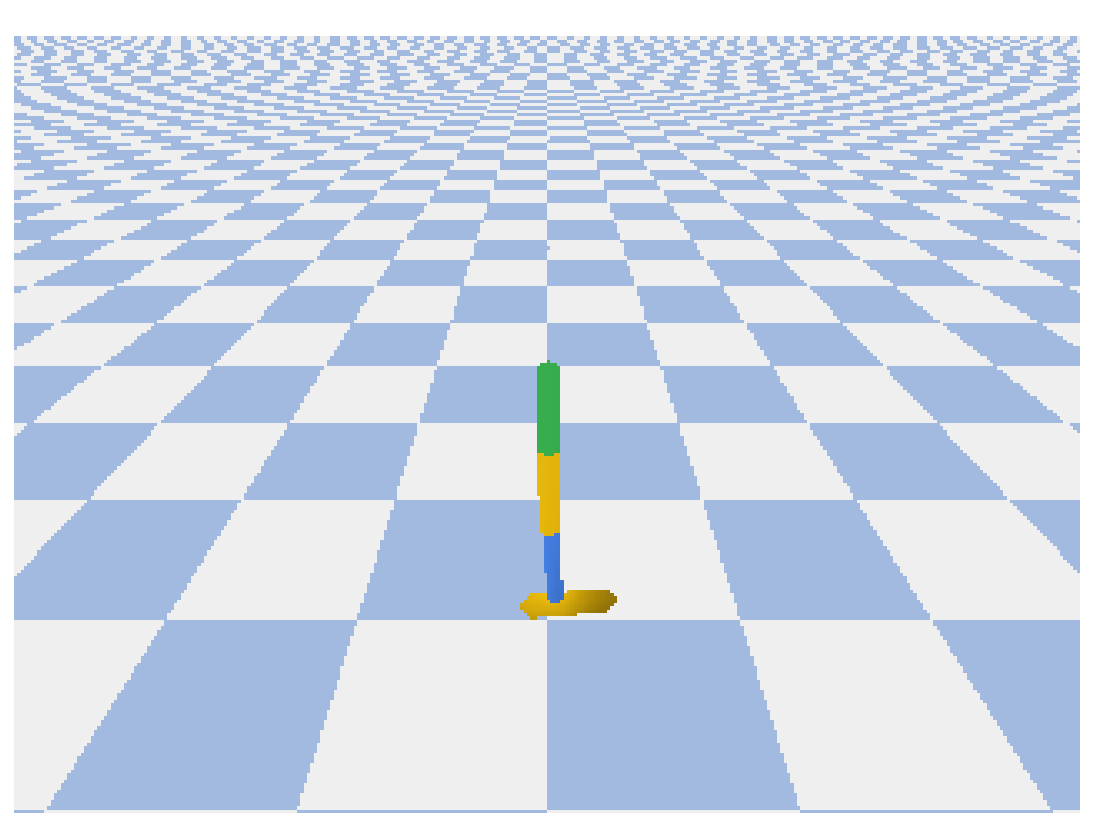

In [ ]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Random Actions

In [ ]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
# for _ in range(n_steps):
#   # Random control of actuators.
#   action = np.random.uniform(action_spec.minimum,
#                              action_spec.maximum,
#                              size=action_spec.shape)
#   timestep = env.step(action)
#   frames.append(env.environment.render(mode='rgb_array'))

# display_video(frames, framerate=20)

# Properties

## Environment Properties

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)


Actions:
 BoundedArray(shape=(3,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])
Observations:
 BoundedArray(shape=(15,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


## Robot properties

In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0. 0. 0.]
torso      [0.   0.   1.25]
link0_3    [0. 0. 0.]
link0_4    [0. 0. 0.]
link0_6    [8.67361738e-19 0.00000000e+00 1.04999995e+00]
thigh      [-0.01683335  0.          0.82563056]
link0_8    [-0.03366669  0.          0.60126118]
leg        [-0.06659153  0.          0.35343874]
link0_10   [-0.09951637  0.          0.1056163 ]
foot       [-0.03479607  0.          0.0995928 ]
floor      [0. 0. 0.]


In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([0., 0., 0.])

# dm-acme agent

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(5e-5)
critic_optimizer = snt.optimizers.Adam(5e-5)

## D4PG agent

In [ ]:
import copy
from typing import Optional

from acme import datasets
from acme import specs
from acme.adders import reverb as adders
from acme.agents import agent
from acme.agents.tf import actors
from acme.agents.tf.dqn import learning
from acme.tf import savers as tf2_savers
from acme.tf import utils as tf2_utils
from acme.utils import loggers
import reverb
import sonnet as snt
import tensorflow as tf
import trfl


class DQN(agent.Agent):
  """DQN agent.
  This implements a single-process DQN agent. This is a simple Q-learning
  algorithm that inserts N-step transitions into a replay buffer, and
  periodically updates its policy by sampling these transitions using
  prioritization.
  """

  def __init__(
      self,
      environment_spec: specs.EnvironmentSpec,
      network: snt.Module,
      batch_size: int = 256,
      prefetch_size: int = 4,
      target_update_period: int = 100,
      samples_per_insert: float = 32.0,
      min_replay_size: int = 1000,
      max_replay_size: int = 1000000,
      importance_sampling_exponent: float = 0.2,
      priority_exponent: float = 0.6,
      n_step: int = 5,
      epsilon: Optional[tf.Variable] = None,
      learning_rate: float = 1e-3,
      discount: float = 0.99,
      logger: Optional[loggers.Logger] = None,
      checkpoint: bool = True,
      checkpoint_subpath: str = '~/acme/',
      policy_network: Optional[snt.Module] = None,
      max_gradient_norm: Optional[float] = None,
  ):
    """Initialize the agent.
    Args:
      environment_spec: description of the actions, observations, etc.
      network: the online Q network (the one being optimized)
      batch_size: batch size for updates.
      prefetch_size: size to prefetch from replay.
      target_update_period: number of learner steps to perform before updating
        the target networks.
      samples_per_insert: number of samples to take from replay for every insert
        that is made.
      min_replay_size: minimum replay size before updating. This and all
        following arguments are related to dataset construction and will be
        ignored if a dataset argument is passed.
      max_replay_size: maximum replay size.
      importance_sampling_exponent: power to which importance weights are raised
        before normalizing.
      priority_exponent: exponent used in prioritized sampling.
      n_step: number of steps to squash into a single transition.
      epsilon: probability of taking a random action; ignored if a policy
        network is given.
      learning_rate: learning rate for the q-network update.
      discount: discount to use for TD updates.
      logger: logger object to be used by learner.
      checkpoint: boolean indicating whether to checkpoint the learner.
      checkpoint_subpath: directory for the checkpoint.
      policy_network: if given, this will be used as the policy network.
        Otherwise, an epsilon greedy policy using the online Q network will be
        created. Policy network is used in the actor to sample actions.
      max_gradient_norm: used for gradient clipping.
    """

    # Create a replay server to add data to. This uses no limiter behavior in
    # order to allow the Agent interface to handle it.
    replay_table = reverb.Table(
        name=adders.DEFAULT_PRIORITY_TABLE,
        sampler=reverb.selectors.Prioritized(priority_exponent),
        remover=reverb.selectors.Fifo(),
        max_size=max_replay_size,
        rate_limiter=reverb.rate_limiters.MinSize(1),
        signature=adders.NStepTransitionAdder.signature(environment_spec))
    self._server = reverb.Server([replay_table], port=None)

    # The adder is used to insert observations into replay.
    address = f'localhost:{self._server.port}'
    adder = adders.NStepTransitionAdder(
        client=reverb.Client(address),
        n_step=n_step,
        discount=discount)

    # The dataset provides an interface to sample from replay.
    replay_client = reverb.Client(address)
    dataset = datasets.make_reverb_dataset(
        server_address=address,
        batch_size=batch_size,
        prefetch_size=prefetch_size)

    # Create epsilon greedy policy network by default.
    if policy_network is None:
      # Use constant 0.05 epsilon greedy policy by default.
      if epsilon is None:
        epsilon = tf.Variable(0.05, trainable=False)
      policy_network = snt.Sequential([
          network,
          lambda q: trfl.epsilon_greedy(q, epsilon=epsilon).sample(),
      ])

    # Create a target network.
    target_network = copy.deepcopy(network)

    # Ensure that we create the variables before proceeding (maybe not needed).
    tf2_utils.create_variables(network, [environment_spec.observations])
    tf2_utils.create_variables(target_network, [environment_spec.observations])

    # Create the actor which defines how we take actions.
    actor = actors.FeedForwardActor(policy_network, adder)

    # The learner updates the parameters (and initializes them).
    learner = learning.DQNLearner(
        network=network,
        target_network=target_network,
        discount=discount,
        importance_sampling_exponent=importance_sampling_exponent,
        learning_rate=learning_rate,
        target_update_period=target_update_period,
        dataset=dataset,
        replay_client=replay_client,
        max_gradient_norm=max_gradient_norm,
        logger=logger,
        checkpoint=checkpoint)

    if checkpoint:
      self._checkpointer = tf2_savers.Checkpointer(
          directory=checkpoint_subpath,
          objects_to_save=learner.state,
          subdirectory='dqn_learner',
          time_delta_minutes=60.)
    else:
      self._checkpointer = None

    super().__init__(
        actor=actor,
        learner=learner,
        min_observations=max(batch_size, min_replay_size),
        observations_per_step=float(batch_size) / samples_per_insert)

  def update(self):
    super().update()
    if self._checkpointer is not None:
      self._checkpointer.save()

In [ ]:
policy_network, critic_network = make_networks_d4pg(action_spec)
agent = DQN(environment_spec=env_spec,
             policy_network=policy_network,
             logger=learner_logger,
             checkpoint=checkpoint)

NameError: ignored

In [ ]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-50.,
                       vmax=50.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=50.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-2)
critic_optimizer = snt.optimizers.Adam(1e-2)

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent_dmpo = DistributionalMPO(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 1000000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


[Learner] Critic Loss = 1.439 | Policy Loss = 0.149 | Steps = 1273 | Walltime = 41.542
[Environment Loop] Episode Length = 28 | Episode Return = 0.15401744842529297 | Episodes = 497 | Steps = 11180 | Steps Per Second = 255.603
[Learner] Critic Loss = 1.373 | Policy Loss = 0.164 | Steps = 3136 | Walltime = 101.572
[Environment Loop] Episode Length = 27 | Episode Return = -4.143807411193848 | Episodes = 1010 | Steps = 26088 | Steps Per Second = 239.397
[Learner] Critic Loss = 1.298 | Policy Loss = 0.137 | Steps = 4998 | Walltime = 161.585
[Environment Loop] Episode Length = 30 | Episode Return = 6.549354076385498 | Episodes = 1522 | Steps = 40984 | Steps Per Second = 244.696
[Learner] Critic Loss = 1.314 | Policy Loss = 0.147 | Steps = 6852 | Walltime = 221.608
[Environment Loop] Episode Length = 29 | Episode Return = 1.8564133644104004 | Episodes = 2032 | Steps = 55814 | Steps Per Second = 257.454
[Learner] Critic Loss = 1.287 | Policy Loss = 0.142 | Steps = 8700 | Walltime = 281.636
[E

INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


[Learner] Critic Loss = 1.236 | Policy Loss = 0.125 | Steps = 56181 | Walltime = 1842.013
[Environment Loop] Episode Length = 28 | Episode Return = 1.300456166267395 | Episodes = 15643 | Steps = 450756 | Steps Per Second = 263.331
[Learner] Critic Loss = 1.132 | Policy Loss = 0.108 | Steps = 57973 | Walltime = 1902.039
[Environment Loop] Episode Length = 28 | Episode Return = 0.739448070526123 | Episodes = 16139 | Steps = 465098 | Steps Per Second = 217.801
[Learner] Critic Loss = 1.156 | Policy Loss = 0.118 | Steps = 59770 | Walltime = 1962.061
[Environment Loop] Episode Length = 29 | Episode Return = 0.11725866794586182 | Episodes = 16636 | Steps = 479501 | Steps Per Second = 245.362
[Learner] Critic Loss = 1.189 | Policy Loss = 0.100 | Steps = 61578 | Walltime = 2022.088
[Environment Loop] Episode Length = 30 | Episode Return = -3.008486747741699 | Episodes = 17134 | Steps = 493969 | Steps Per Second = 240.417
[Learner] Critic Loss = 1.255 | Policy Loss = 0.115 | Steps = 63377 | Wal

[Learner] Critic Loss = 1.204 | Policy Loss = 0.121 | Steps = 74308 | Walltime = 2442.229
[Environment Loop] Episode Length = 28 | Episode Return = -1.5080848932266235 | Episodes = 20648 | Steps = 595879 | Steps Per Second = 261.062
[Learner] Critic Loss = 1.253 | Policy Loss = 0.130 | Steps = 76137 | Walltime = 2502.264
[Environment Loop] Episode Length = 26 | Episode Return = -1.8940550088882446 | Episodes = 21151 | Steps = 610514 | Steps Per Second = 252.462
[Learner] Critic Loss = 1.188 | Policy Loss = 0.110 | Steps = 77983 | Walltime = 2562.277
[Environment Loop] Episode Length = 29 | Episode Return = -0.673576831817627 | Episodes = 21661 | Steps = 625302 | Steps Per Second = 272.287
[Learner] Critic Loss = 1.213 | Policy Loss = 0.111 | Steps = 79826 | Walltime = 2622.284
[Environment Loop] Episode Length = 29 | Episode Return = -1.651597023010254 | Episodes = 22169 | Steps = 640071 | Steps Per Second = 250.928
[Learner] Critic Loss = 1.282 | Policy Loss = 0.134 | Steps = 81673 | 

[Learner] Critic Loss = 1.175 | Policy Loss = 0.113 | Steps = 92714 | Walltime = 3042.386
[Environment Loop] Episode Length = 30 | Episode Return = 0.49744123220443726 | Episodes = 25726 | Steps = 743217 | Steps Per Second = 224.793
[Learner] Critic Loss = 1.171 | Policy Loss = 0.115 | Steps = 94546 | Walltime = 3102.417
[Environment Loop] Episode Length = 27 | Episode Return = -2.143280267715454 | Episodes = 26231 | Steps = 757895 | Steps Per Second = 249.507
[Learner] Critic Loss = 1.218 | Policy Loss = 0.113 | Steps = 96389 | Walltime = 3162.421
[Environment Loop] Episode Length = 29 | Episode Return = 0.510385274887085 | Episodes = 26738 | Steps = 772629 | Steps Per Second = 255.729
[Learner] Critic Loss = 1.203 | Policy Loss = 0.125 | Steps = 98228 | Walltime = 3222.437
[Environment Loop] Episode Length = 28 | Episode Return = 1.7501063346862793 | Episodes = 27244 | Steps = 787361 | Steps Per Second = 229.712
[Learner] Critic Loss = 1.177 | Policy Loss = 0.133 | Steps = 100073 | W

INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


INFO:tensorflow:Assets written to: /root/acme/a5127e00-0068-11ec-b179-0242ac1c0002/snapshots/critic/assets


[Learner] Critic Loss = 1.160 | Policy Loss = 0.117 | Steps = 111122 | Walltime = 3642.541
[Environment Loop] Episode Length = 29 | Episode Return = 0.35393226146698 | Episodes = 30803 | Steps = 890589 | Steps Per Second = 259.505
[Learner] Critic Loss = 1.171 | Policy Loss = 0.109 | Steps = 112946 | Walltime = 3702.547
[Environment Loop] Episode Length = 29 | Episode Return = -1.7164994478225708 | Episodes = 31305 | Steps = 905168 | Steps Per Second = 241.577
[Learner] Critic Loss = 1.232 | Policy Loss = 0.124 | Steps = 114778 | Walltime = 3762.572
[Environment Loop] Episode Length = 29 | Episode Return = 3.7736268043518066 | Episodes = 31811 | Steps = 919843 | Steps Per Second = 235.149
[Learner] Critic Loss = 1.206 | Policy Loss = 0.121 | Steps = 116614 | Walltime = 3822.572
[Environment Loop] Episode Length = 29 | Episode Return = -2.299560070037842 | Episodes = 32318 | Steps = 934556 | Steps Per Second = 224.200
[Learner] Critic Loss = 1.210 | Policy Loss = 0.112 | Steps = 118446 

















## Examine trained policy

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 2000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

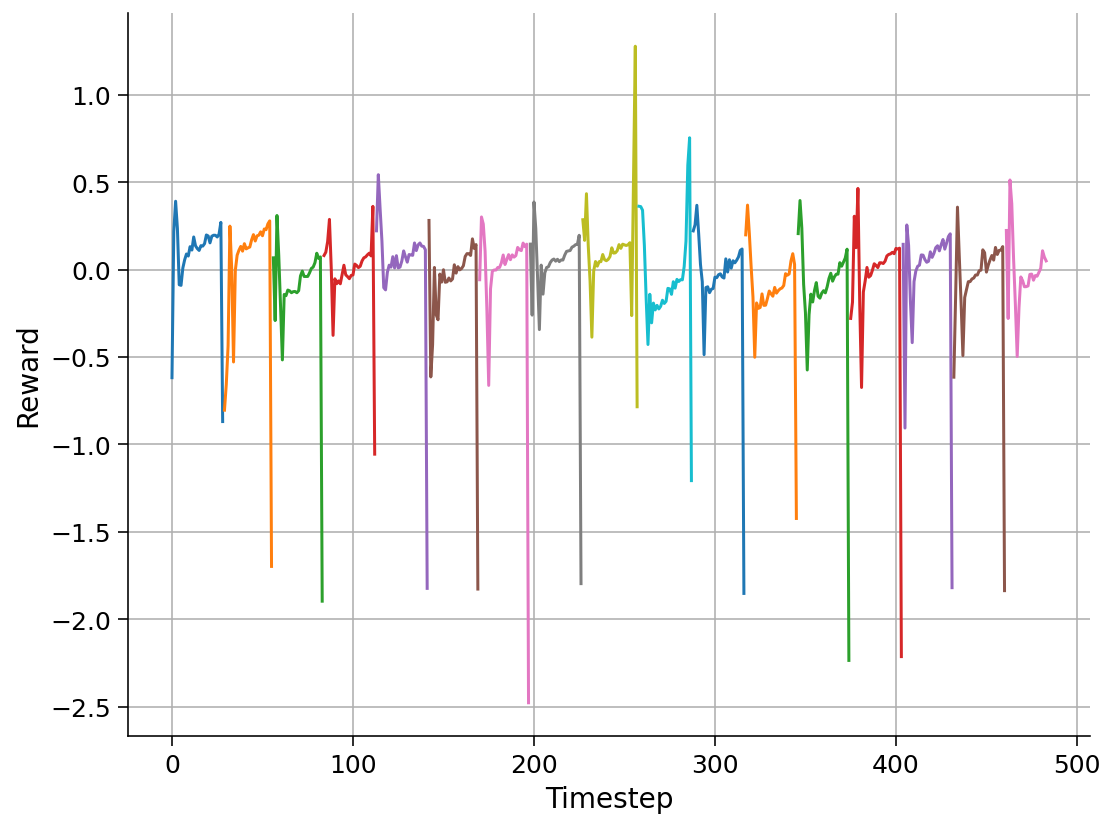

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 100000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

[Learner] Critic Loss = 12.592 | Policy Loss = 0.500 | Steps = 1130 | Walltime = 327.276
[Environment Loop] Episode Length = 56 | Episode Return = 54.18745422363281 | Episodes = 1 | Steps = 56 | Steps Per Second = 47.356
[Learner] Critic Loss = 29.900 | Policy Loss = 0.500 | Steps = 1640 | Walltime = 387.641
[Environment Loop] Episode Length = 33 | Episode Return = 62.82626724243164 | Episodes = 98 | Steps = 4137 | Steps Per Second = 64.849
[Learner] Critic Loss = 38.346 | Policy Loss = 0.500 | Steps = 2174 | Walltime = 447.644
[Environment Loop] Episode Length = 54 | Episode Return = 54.07366180419922 | Episodes = 198 | Steps = 8429 | Steps Per Second = 69.151
[Learner] Critic Loss = 54.520 | Policy Loss = 0.500 | Steps = 2708 | Walltime = 507.648
[Environment Loop] Episode Length = 67 | Episode Return = 101.19804382324219 | Episodes = 269 | Steps = 12731 | Steps Per Second = 70.428
[Learner] Critic Loss = 52.379 | Policy Loss = 0.500 | Steps = 3253 | Walltime = 567.649
[Environment L

[Learner] Critic Loss = 75.037 | Policy Loss = 0.500 | Steps = 3784 | Walltime = 627.696
[Environment Loop] Episode Length = 47 | Episode Return = 75.61067962646484 | Episodes = 416 | Steps = 21366 | Steps Per Second = 82.077
[Learner] Critic Loss = 64.559 | Policy Loss = 0.500 | Steps = 4337 | Walltime = 688.048
[Environment Loop] Episode Length = 66 | Episode Return = 95.97559356689453 | Episodes = 487 | Steps = 25826 | Steps Per Second = 64.628
[Learner] Critic Loss = 80.684 | Policy Loss = 0.500 | Steps = 4886 | Walltime = 748.149
[Environment Loop] Episode Length = 65 | Episode Return = 51.34516143798828 | Episodes = 555 | Steps = 30249 | Steps Per Second = 67.600
[Learner] Critic Loss = 87.601 | Policy Loss = 0.500 | Steps = 5437 | Walltime = 808.164
[Environment Loop] Episode Length = 60 | Episode Return = 54.91743850708008 | Episodes = 625 | Steps = 34685 | Steps Per Second = 76.206
[Learner] Critic Loss = 72.138 | Policy Loss = 0.500 | Steps = 6008 | Walltime = 868.192
[Enviro

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

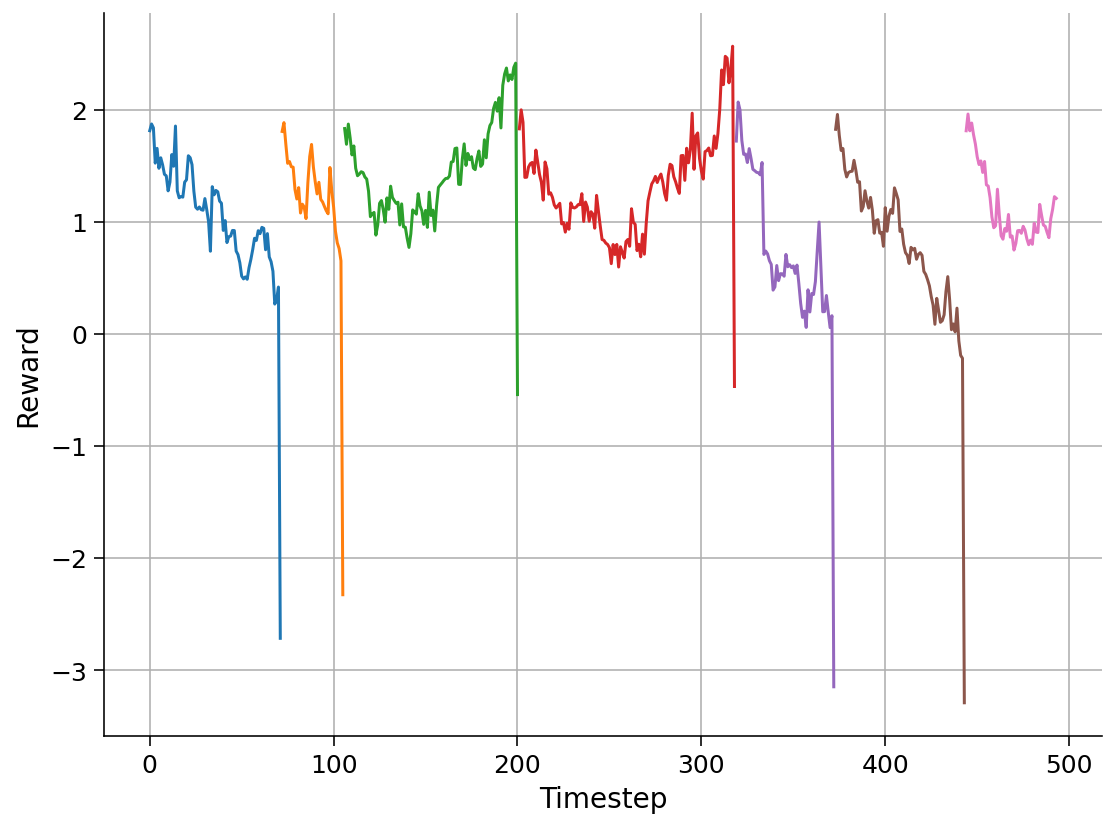

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [ ]:
class Walker2D(WalkerBase):
  foot_list = ["foot", "foot_left"]

  def __init__(self):
    WalkerBase.__init__(self, "walker2d.xml", "torso", action_dim=6, obs_dim=22, power=0.40)

  def alive_bonus(self, z, pitch):
    return +1 if z > 0.8 and abs(pitch) < 1.0 else -1

  def robot_specific_reset(self, bullet_client):
    WalkerBase.robot_specific_reset(self, bullet_client)
    for n in ["foot_joint", "foot_left_joint"]:
      self.jdict[n].power_coef = 30.0

NameError: ignored

In [ ]:
import pybullet_data

In [ ]:
class WalkerBase(MJCFBasedRobot):

  def __init__(self, fn, robot_name, action_dim, obs_dim, power):
    MJCFBasedRobot.__init__(self, fn, robot_name, action_dim, obs_dim)
    self.power = power
    self.camera_x = 0
    self.start_pos_x, self.start_pos_y, self.start_pos_z = 0, 0, 0
    self.walk_target_x = 1e3  # kilometer away
    self.walk_target_y = 0
    self.body_xyz = [0, 0, 0]

  def robot_specific_reset(self, bullet_client):
    self._p = bullet_client
    for j in self.ordered_joints:
      j.reset_current_position(self.np_random.uniform(low=-0.1, high=0.1), 0)

    self.feet = [self.parts[f] for f in self.foot_list]
    self.feet_contact = np.array([0.0 for f in self.foot_list], dtype=np.float32)
    self.scene.actor_introduce(self)
    self.initial_z = None

  def apply_action(self, a):
    assert (np.isfinite(a).all())
    for n, j in enumerate(self.ordered_joints):
      j.set_motor_torque(self.power * j.power_coef * float(np.clip(a[n], -1, +1)))

  def calc_state(self):
    j = np.array([j.current_relative_position() for j in self.ordered_joints],
                 dtype=np.float32).flatten()
    # even elements [0::2] position, scaled to -1..+1 between limits
    # odd elements  [1::2] angular speed, scaled to show -1..+1
    self.joint_speeds = j[1::2]
    self.joints_at_limit = np.count_nonzero(np.abs(j[0::2]) > 0.99)

    body_pose = self.robot_body.pose()
    parts_xyz = np.array([p.pose().xyz() for p in self.parts.values()]).flatten()
    self.body_xyz = (parts_xyz[0::3].mean(), parts_xyz[1::3].mean(), body_pose.xyz()[2]
                    )  # torso z is more informative than mean z
    self.body_real_xyz = body_pose.xyz()
    self.body_rpy = body_pose.rpy()
    z = self.body_xyz[2]
    if self.initial_z == None:
      self.initial_z = z
    r, p, yaw = self.body_rpy
    self.walk_target_theta = np.arctan2(self.walk_target_y - self.body_xyz[1],
                                        self.walk_target_x - self.body_xyz[0])
    self.walk_target_dist = np.linalg.norm(
        [self.walk_target_y - self.body_xyz[1], self.walk_target_x - self.body_xyz[0]])
    angle_to_target = self.walk_target_theta - yaw

    rot_speed = np.array([[np.cos(-yaw), -np.sin(-yaw), 0], [np.sin(-yaw),
                                                             np.cos(-yaw), 0], [0, 0, 1]])
    vx, vy, vz = np.dot(rot_speed,
                        self.robot_body.speed())  # rotate speed back to body point of view

    more = np.array(
        [
            z - self.initial_z,
            np.sin(angle_to_target),
            np.cos(angle_to_target),
            0.3 * vx,
            0.3 * vy,
            0.3 * vz,  # 0.3 is just scaling typical speed into -1..+1, no physical sense here
            r,
            p
        ],
        dtype=np.float32)
    return np.clip(np.concatenate([more] + [j] + [self.feet_contact]), -5, +5)

  def calc_potential(self):
    # progress in potential field is speed*dt, typical speed is about 2-3 meter per second, this potential will change 2-3 per frame (not per second),
    # all rewards have rew/frame units and close to 1.0
    debugmode = 0
    if (debugmode):
      print("calc_potential: self.walk_target_dist")
      print(self.walk_target_dist)
      print("self.scene.dt")
      print(self.scene.dt)
      print("self.scene.frame_skip")
      print(self.scene.frame_skip)
      print("self.scene.timestep")
      print(self.scene.timestep)
    return -self.walk_target_dist / self.scene.dt


In [ ]:
class XmlBasedRobot:
  """
	Base class for mujoco .xml based agents.
	"""

  self_collision = True

  def __init__(self, robot_name, action_dim, obs_dim, self_collision):
    self.parts = None
    self.objects = []
    self.jdict = None
    self.ordered_joints = None
    self.robot_body = None

    high = np.ones([action_dim])
    self.action_space = gym.spaces.Box(-high, high)
    high = np.inf * np.ones([obs_dim])
    self.observation_space = gym.spaces.Box(-high, high)

    #self.model_xml = model_xml
    self.robot_name = robot_name
    self.self_collision = self_collision

  def addToScene(self, bullet_client, bodies):
    self._p = bullet_client

    if self.parts is not None:
      parts = self.parts
    else:
      parts = {}

    if self.jdict is not None:
      joints = self.jdict
    else:
      joints = {}

    if self.ordered_joints is not None:
      ordered_joints = self.ordered_joints
    else:
      ordered_joints = []

    if np.isscalar(bodies):  # streamline the case where bodies is actually just one body
      bodies = [bodies]

    dump = 0
    for i in range(len(bodies)):
      if self._p.getNumJoints(bodies[i]) == 0:
        part_name, robot_name = self._p.getBodyInfo(bodies[i])
        self.robot_name = robot_name.decode("utf8")
        part_name = part_name.decode("utf8")
        parts[part_name] = BodyPart(self._p, part_name, bodies, i, -1)
      for j in range(self._p.getNumJoints(bodies[i])):
        self._p.setJointMotorControl2(bodies[i],
                                      j,
                                      pybullet.POSITION_CONTROL,
                                      positionGain=0.1,
                                      velocityGain=0.1,
                                      force=0)
        jointInfo = self._p.getJointInfo(bodies[i], j)
        joint_name = jointInfo[1]
        part_name = jointInfo[12]

        joint_name = joint_name.decode("utf8")
        part_name = part_name.decode("utf8")

        if dump: print("ROBOT PART '%s'" % part_name)
        if dump:
          print(
              "ROBOT JOINT '%s'" % joint_name
          )  # limits = %+0.2f..%+0.2f effort=%0.3f speed=%0.3f" % ((joint_name,) + j.limits()) )

        parts[part_name] = BodyPart(self._p, part_name, bodies, i, j)

        if part_name == self.robot_name:
          self.robot_body = parts[part_name]

        if i == 0 and j == 0 and self.robot_body is None:  # if nothing else works, we take this as robot_body
          parts[self.robot_name] = BodyPart(self._p, self.robot_name, bodies, 0, -1)
          self.robot_body = parts[self.robot_name]

        if joint_name[:6] == "ignore":
          Joint(self._p, joint_name, bodies, i, j).disable_motor()
          continue

        if joint_name[:8] != "jointfix":
          joints[joint_name] = Joint(self._p, joint_name, bodies, i, j)
          ordered_joints.append(joints[joint_name])

          joints[joint_name].power_coef = 100.0

        # TODO: Maybe we need this
        # joints[joint_name].power_coef, joints[joint_name].max_velocity = joints[joint_name].limits()[2:4]
        # self.ordered_joints.append(joints[joint_name])
        # self.jdict[joint_name] = joints[joint_name]

    return parts, joints, ordered_joints, self.robot_body

  def reset_pose(self, position, orientation):
    self.parts[self.robot_name].reset_pose(position, orientation)


class MJCFBasedRobot(XmlBasedRobot):
  """
	Base class for mujoco .xml based agents.
	"""

  def __init__(self, model_xml, robot_name, action_dim, obs_dim, self_collision=True):
    XmlBasedRobot.__init__(self, robot_name, action_dim, obs_dim, self_collision)
    self.model_xml = model_xml
    self.doneLoading = 0

  def reset(self, bullet_client):

    self._p = bullet_client
    #print("Created bullet_client with id=", self._p._client)
    if (self.doneLoading == 0):
      self.ordered_joints = []
      self.doneLoading = 1
      if self.self_collision:
        self.objects = self._p.loadMJCF(os.path.join(pybullet_data.getDataPath(), "mjcf",
                                                     self.model_xml),
                                        flags=pybullet.URDF_USE_SELF_COLLISION |
                                        pybullet.URDF_USE_SELF_COLLISION_EXCLUDE_ALL_PARENTS |
                                        pybullet.URDF_GOOGLEY_UNDEFINED_COLORS )
        self.parts, self.jdict, self.ordered_joints, self.robot_body = self.addToScene(
            self._p, self.objects)
      else:
        self.objects = self._p.loadMJCF(
            os.path.join(pybullet_data.getDataPath(), "mjcf", self.model_xml, flags = pybullet.URDF_GOOGLEY_UNDEFINED_COLORS))
        self.parts, self.jdict, self.ordered_joints, self.robot_body = self.addToScene(
            self._p, self.objects)
    self.robot_specific_reset(self._p)

    s = self.calc_state(
    )  # optimization: calc_state() can calculate something in self.* for calc_potential() to use

    return s

  def calc_potential(self):
    return 0


In [ ]:
class Walker2D(WalkerBase):
  foot_list = ["foot", "foot_left"]

  def __init__(self):
    WalkerBase.__init__(self, "walker2d.xml", "torso", action_dim=6, obs_dim=22, power=0.40)

  def alive_bonus(self, z, pitch):
    return +1 if z > 0.8 and abs(pitch) < 1.0 else -1

  def robot_specific_reset(self, bullet_client):
    WalkerBase.robot_specific_reset(self, bullet_client)
    for n in ["foot_joint", "foot_left_joint"]:
      self.jdict[n].power_coef = 30.0

In [ ]:
class Humanoid(WalkerBase):
  self_collision = True
  foot_list = ["right_foot", "left_foot"]  # "left_hand", "right_hand"

  def __init__(self):
    WalkerBase.__init__(self,
                        'humanoid_symmetric.xml',
                        'torso',
                        action_dim=17,
                        obs_dim=44,
                        power=0.41)
    # 17 joints, 4 of them important for walking (hip, knee), others may as well be turned off, 17/4 = 4.25

  def robot_specific_reset(self, bullet_client):
    WalkerBase.robot_specific_reset(self, bullet_client)
    self.motor_names = ["abdomen_z", "abdomen_y", "abdomen_x"]
    self.motor_power = [100, 100, 100]
    self.motor_names += ["right_hip_x", "right_hip_z", "right_hip_y", "right_knee"]
    self.motor_power += [100, 100, 300, 200]
    self.motor_names += ["left_hip_x", "left_hip_z", "left_hip_y", "left_knee"]
    self.motor_power += [100, 100, 300, 200]
    self.motor_names += ["right_shoulder1", "right_shoulder2", "right_elbow"]
    self.motor_power += [75, 75, 75]
    self.motor_names += ["left_shoulder1", "left_shoulder2", "left_elbow"]
    self.motor_power += [75, 75, 75]
    self.motors = [self.jdict[n] for n in self.motor_names]
    if self.random_yaw:
      position = [0, 0, 0]
      orientation = [0, 0, 0]
      yaw = self.np_random.uniform(low=-3.14, high=3.14)
      if self.random_lean and self.np_random.randint(2) == 0:
        cpose.set_xyz(0, 0, 1.4)
        if self.np_random.randint(2) == 0:
          pitch = np.pi / 2
          position = [0, 0, 0.45]
        else:
          pitch = np.pi * 3 / 2
          position = [0, 0, 0.25]
        roll = 0
        orientation = [roll, pitch, yaw]
      else:
        position = [0, 0, 1.4]
        orientation = [0, 0, yaw]  # just face random direction, but stay straight otherwise
      self.robot_body.reset_position(position)
      self.robot_body.reset_orientation(orientation)
    self.initial_z = 0.8

  random_yaw = False
  random_lean = False

  def apply_action(self, a):
    assert (np.isfinite(a).all())
    force_gain = 1
    for i, m, power in zip(range(17), self.motors, self.motor_power):
      m.set_motor_torque(float(force_gain * power * self.power * np.clip(a[i], -1, +1)))

  def alive_bonus(self, z, pitch):
    return +2 if z > 0.78 else -1  # 2 here because 17 joints produce a lot of electricity cost just from policy noise, living must be better than dying


def get_cube(_p, x, y, z):
  body = _p.loadURDF(os.path.join(pybullet_data.getDataPath(), "cube_small.urdf"), [x, y, z])
  _p.changeDynamics(body, -1, mass=1.2)  #match Roboschool
  part_name, _ = _p.getBodyInfo(body)
  part_name = part_name.decode("utf8")
  bodies = [body]
  return BodyPart(_p, part_name, bodies, 0, -1)


def get_sphere(_p, x, y, z):
  body = _p.loadURDF(os.path.join(pybullet_data.getDataPath(), "sphere2red_nocol.urdf"), [x, y, z])
  part_name, _ = _p.getBodyInfo(body)
  part_name = part_name.decode("utf8")
  bodies = [body]
  return BodyPart(_p, part_name, bodies, 0, -1)


class HumanoidFlagrun(Humanoid):

  def __init__(self):
    Humanoid.__init__(self)
    self.flag = None

  def robot_specific_reset(self, bullet_client):
    Humanoid.robot_specific_reset(self, bullet_client)
    self.flag_reposition()

  def flag_reposition(self):
    self.walk_target_x = self.np_random.uniform(low=-self.scene.stadium_halflen,
                                                high=+self.scene.stadium_halflen)
    self.walk_target_y = self.np_random.uniform(low=-self.scene.stadium_halfwidth,
                                                high=+self.scene.stadium_halfwidth)
    more_compact = 0.5  # set to 1.0 whole football field
    self.walk_target_x *= more_compact
    self.walk_target_y *= more_compact

    if (self.flag):
      #for b in self.flag.bodies:
      #	print("remove body uid",b)
      #	p.removeBody(b)
      self._p.resetBasePositionAndOrientation(self.flag.bodies[0],
                                              [self.walk_target_x, self.walk_target_y, 0.7],
                                              [0, 0, 0, 1])
    else:
      self.flag = get_sphere(self._p, self.walk_target_x, self.walk_target_y, 0.7)
    self.flag_timeout = 600 / self.scene.frame_skip  #match Roboschool

  def calc_state(self):
    self.flag_timeout -= 1
    state = Humanoid.calc_state(self)
    if self.walk_target_dist < 1 or self.flag_timeout <= 0:
      self.flag_reposition()
      state = Humanoid.calc_state(self)  # caclulate state again, against new flag pos
      self.potential = self.calc_potential()  # avoid reward jump
    return state


class HumanoidFlagrunHarder(HumanoidFlagrun):

  def __init__(self):
    HumanoidFlagrun.__init__(self)
    self.flag = None
    self.aggressive_cube = None
    self.frame = 0

  def robot_specific_reset(self, bullet_client):

    HumanoidFlagrun.robot_specific_reset(self, bullet_client)

    self.frame = 0
    if (self.aggressive_cube):
      self._p.resetBasePositionAndOrientation(self.aggressive_cube.bodies[0], [-1.5, 0, 0.05],
                                              [0, 0, 0, 1])
    else:
      self.aggressive_cube = get_cube(self._p, -1.5, 0, 0.05)
    self.on_ground_frame_counter = 0
    self.crawl_start_potential = None
    self.crawl_ignored_potential = 0.0
    self.initial_z = 0.8

  def alive_bonus(self, z, pitch):
    if self.frame % 30 == 0 and self.frame > 100 and self.on_ground_frame_counter == 0:
      target_xyz = np.array(self.body_xyz)
      robot_speed = np.array(self.robot_body.speed())
      angle = self.np_random.uniform(low=-3.14, high=3.14)
      from_dist = 4.0
      attack_speed = self.np_random.uniform(
          low=20.0, high=30.0)  # speed 20..30 (* mass in cube.urdf = impulse)
      time_to_travel = from_dist / attack_speed
      target_xyz += robot_speed * time_to_travel  # predict future position at the moment the cube hits the robot
      position = [
          target_xyz[0] + from_dist * np.cos(angle), target_xyz[1] + from_dist * np.sin(angle),
          target_xyz[2] + 1.0
      ]
      attack_speed_vector = target_xyz - np.array(position)
      attack_speed_vector *= attack_speed / np.linalg.norm(attack_speed_vector)
      attack_speed_vector += self.np_random.uniform(low=-1.0, high=+1.0, size=(3,))
      self.aggressive_cube.reset_position(position)
      self.aggressive_cube.reset_velocity(linearVelocity=attack_speed_vector)
    if z < 0.8:
      self.on_ground_frame_counter += 1
    elif self.on_ground_frame_counter > 0:
      self.on_ground_frame_counter -= 1
    # End episode if the robot can't get up in 170 frames, to save computation and decorrelate observations.
    self.frame += 1
    return self.potential_leak() if self.on_ground_frame_counter < 170 else -1

  def potential_leak(self):
    z = self.body_xyz[2]  # 0.00 .. 0.8 .. 1.05 normal walk, 1.2 when jumping
    z = np.clip(z, 0, 0.8)
    return z / 0.8 + 1.0  # 1.00 .. 2.0

  def calc_potential(self):
    # We see alive bonus here as a leak from potential field. Value V(s) of a given state equals
    # potential, if it is topped up with gamma*potential every frame. Gamma is assumed 0.99.
    #
    # 2.0 alive bonus if z>0.8, potential is 200, leak gamma=0.99, (1-0.99)*200==2.0
    # 1.0 alive bonus on the ground z==0, potential is 100, leak (1-0.99)*100==1.0
    #
    # Why robot whould stand up: to receive 100 points in potential field difference.
    flag_running_progress = Humanoid.calc_potential(self)

    # This disables crawl.
    if self.body_xyz[2] < 0.8:
      if self.crawl_start_potential is None:
        self.crawl_start_potential = flag_running_progress - self.crawl_ignored_potential
        #print("CRAWL START %+0.1f %+0.1f" % (self.crawl_start_potential, flag_running_progress))
      self.crawl_ignored_potential = flag_running_progress - self.crawl_start_potential
      flag_running_progress = self.crawl_start_potential
    else:
      #print("CRAWL STOP %+0.1f %+0.1f" % (self.crawl_ignored_potential, flag_running_progress))
      flag_running_progress -= self.crawl_ignored_potential
      self.crawl_start_potential = None

    return flag_running_progress + self.potential_leak() * 100